In [1]:
# ---- now load your Julia stack ----
using MCMCChains
using MCMCDiagnosticTools
using AdvancedMH
using Distributions
using Random
using LinearAlgebra
using LoopVectorization
using DataFrames
using CSV
using Printf
using HDF5
using MCMCChainsStorage
using StatsPlots
using Base.Threads
using NPZ

# ---- make Python visible to Julia and import your module ----
using PyCall
py"""
import sys
sys.path.insert(0, "/home/vincent/PhD/Projects/Memilio_PF/seirdb_ebola")
"""

# ---- include your local code after PyCall is ready ----
include(joinpath(@__DIR__, "../SimParticleFilter", "ParticleFilter_Sim.jl"))
include(joinpath(@__DIR__, "../SimParticleFilter", "PythonSimulator.jl"))
include(joinpath(@__DIR__, "../SimParticleFilter", "ResamplingAlgorithms.jl"))
include(joinpath(@__DIR__, "../SimParticleFilter", "BootstrapFilter_Sim.jl"))
include(joinpath(@__DIR__, "../SimParticleFilter", "Utilities_Sim.jl"))

create_cache (generic function with 1 method)

In [2]:
using Distributions, Plots

function nb_quantile_bands(mu, r; lower=0.05, upper=0.95)
    probs = r ./ (r .+ mu)
    p = [if k >= 1.0 0.99999 else k end for k in probs]
    ql = similar(mu)
    qm = similar(mu)
    qu = similar(mu)

    for i in eachindex(mu)
        dist = NegativeBinomial(r, p[i])
        ql[i] = quantile(dist, lower)
        qm[i] = mu[i]                 # mean curve
        qu[i] = quantile(dist, upper)
    end

    return ql, qm, qu
end

nb_quantile_bands (generic function with 1 method)

In [3]:
using Logging
# set loglevel to debug
global_logger(SimpleLogger(stderr, Logging.Debug))

SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(23) open, 0 bytes waiting)), VSCodeServer.io_send_callback), ReentrantLock(), Info, Dict{Any, Int64}())

In [ ]:
simulation_function = pyimport("seirdb")["seirdb_flow"]

PyObject <function flow_seirdb at 0x7282e7be6f20>

## Initial settings
We use data from the early outbreak of Ebola in Guinea (only case data, no deaths).

In [5]:
# set default start parameters and initial conditions
p = [0.0055, 5.0, 4.0, 0.53, 0.025, 2.0]
N = 10000000.0
E0 = 0.0
I0 = 10.0
R0 = 0.0
D0 = 0.0
B0 = 0.0
S0 = N-(E0+I0+R0+D0+B0)
t_initial = 0.0
u_initial = [0.0, 0.0, 0.0, 0.0, 0.0]  # Initial flow values
x_initial = [S0, E0, I0, R0, D0, B0]  # Example initial state vector S, E, I, R, D, B

# initialize the simulator
seirdb_simulator = MemFlowSEIRSimulator(simulation_function, p, t_initial, u_initial, x_initial)

MemFlowSEIRSimulator{Vector{Float64}, Vector{Float64}}(PyObject <function flow_seirdb at 0x7282e7be6f20>, [0.0055, 5.0, 4.0, 0.53, 0.025, 2.0], 0.0, 0.0, [0.0, 0.0, 0.0, 0.0, 0.0], [9.99999e6, 0.0, 10.0, 0.0, 0.0, 0.0], [9.99999e6, 0.0, 10.0, 0.0, 0.0, 0.0])

In [6]:
data = CSV.read(joinpath(@__DIR__, "data", "cut_early_guinea_conf_cases.csv"), DataFrame)
tobs = data.Date
observations = data.new_cases;

## Noise model
We use negative binomial noise with a fixed dispersion

In [7]:
dispersion = 5.0; # not yet estimated

In [8]:
function nb_log_obs_prob(x, y, t) # needs to be able to take missing values
    case_flow = x[2]  # flow value for E -> I
    prob_cases = min(0.99999, dispersion / (dispersion + case_flow))
    if (y === missing) || (ismissing(y[1])) 
        return 0.0 # log(1)
    end
    # y = convert(Vector{Float64}, y) # convert from Union{Float64, Missing} to Float64
    y = collect(skipmissing(y))
    return sum(logpdf.(NegativeBinomial(dispersion, prob_cases), y))
end

nb_log_obs_prob (generic function with 1 method)

## Bootstrap Filter

In [9]:
nparticles = 10;

In [10]:
function log_likelihood(θ)
    
    # Update the parameters in the simulator
    seirdb_simulator = MemFlowSEIRSimulator(simulation_function, θ, t_initial, u_initial, x_initial)

    # Initialize the BootstrapFilter
    bf = BootstrapFilter(
        seirdb_simulator, nb_log_obs_prob, tobs, observations, nparticles
    )

    # Run the filter
    log_likeli = run_filter(bf)

    # Return the log-likelihood
    return log_likeli
end

log_likelihood (generic function with 1 method)

In [11]:
# test
log_likelihood(p)

-3031.6633256310142

┌ Debug: Found an embedded environment
│   mime_type[] = svg
│   file_path[] = /tmp/jl_7sXcDejkhG.svg
│   ENV["GKSwstype"] = svg
│   ENV["GKS_FILEPATH"] = /tmp/jl_7sXcDejkhG.svg
└ @ GR /home/vincent/.julia/packages/GR/GVmAc/src/GR.jl:366
┌ Debug: Default GKS_ENCODING
│   ENV["GKS_ENCODING"] = utf8
└ @ GR /home/vincent/.julia/packages/GR/GVmAc/src/GR.jl:392


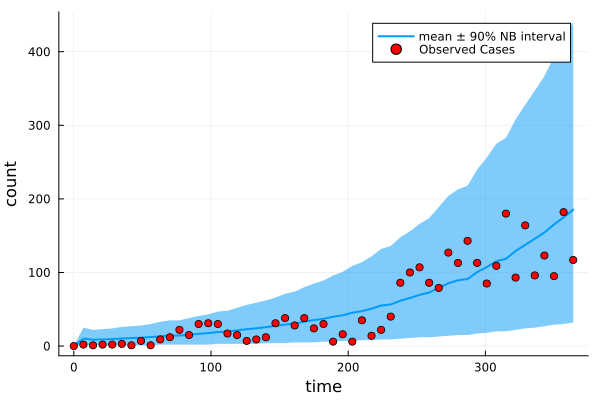

In [12]:
testp = [0.0071, 5, 4.0, 0.53, 0.025, 2.0]


seirdb_simulator = MemFlowSEIRSimulator(simulation_function, testp, t_initial, u_initial, x_initial)
sim = full_simulation(seirdb_simulator, 487.0)
compartments = sim[1]
flows = sim[2];
tobs_ind = collect(skipmissing([flows[1,i] in tobs ? i : missing for i in 1:length(flows[1,:])]));
flows_obs = flows[2:end, tobs_ind];

ql, meanline, qu = nb_quantile_bands(diff([0; flows_obs[1,:]]), 2.0;
                                     lower = 0.05,
                                     upper = 0.95)

plt = plot(
    tobs, meanline,
    ribbon = (meanline .- ql, qu .- meanline),
    label = "mean ± 90% NB interval",
    xlabel = "time",
    ylabel = "count",
    lw = 2
)
plot!(plt, tobs, [obs[1] for obs in observations], seriestype = :scatter, label = "Observed Cases", color = :red)
display(plt)

log_likelis = []
push!(log_likelis, nb_log_obs_prob(flows_obs[:,1], [observations[1]], 1))
for i in 2:length(tobs)
    x = flows_obs[:,i].-flows_obs[:,i-1]
    if any(x .< 0)
        # println(i)
        x = [if k < 0.0 0.0 else k end for k in flows_obs[:,i].-flows_obs[:,i-1]]
    end
    y = observations[i]
    push!(log_likelis, nb_log_obs_prob(x, y, flows[1, i]))
end

In [16]:
println(sum(log_likelis))
println(log_likelihood(testp))

-333.1565099210858
-332.88270424908177


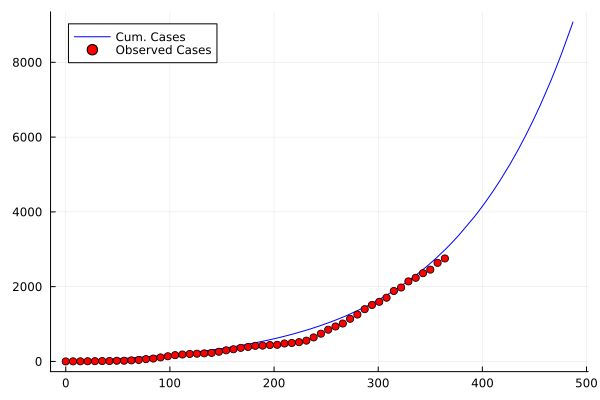

In [21]:
plt = plot(flows[1,:], flows[2,:], label = "Cum. Cases", color = :blue)
plot!(plt, tobs, cumsum([obs[1] for obs in observations]), seriestype = :scatter, label = "Observed Cases", color = :red)

## Results

### Cutted early
Cutted at drop

In [25]:
include("utilities.jl")

posterior_predictive_plot

In [16]:
dispersion = 5.0

files_list = [
    "./output/seirdb_cut_early_flow_$(dispersion)disp_10p_0ch_100000s.h5",
    "./output/seirdb_cut_early_flow_$(dispersion)disp_10p_1ch_100000s.h5",
    "./output/seirdb_cut_early_flow_$(dispersion)disp_10p_2ch_100000s.h5",
    "./output/seirdb_cut_early_flow_$(dispersion)disp_10p_3ch_100000s.h5",
]

chains_list = [h5open(file, "r") do f read(f, Chains) end for file in files_list]

chain_vals = [chains_list[i].value.data for i in 1:4]

complete_chain = MCMCChains.Chains(cat(chain_vals..., dims=(3,3)), [:lp, :rI, :TE, :TI, :pR, :rD, :TB])
complete_chain = MCMCChains.set_section(complete_chain, Dict(:parameters => [:rI, :TE, :TI, :pR, :rD, :TB], :internals => [:lp]))

burnin = 50000
mixed_chain = complete_chain[burnin:end]

Chains MCMC chain (50002×7×4 Array{Float64, 3}):

Iterations        = 50000:1:100001
Number of chains  = 4
Samples per chain = 50002
parameters        = rI, TE, TI, pR, rD, TB
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk    ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64    Float64     Float64   Float64    ⋯

          rI    0.0068    0.0032    0.0001   482.7417    624.9065    1.7078    ⋯
          TE    8.9862    3.3624    0.1205   778.5772   1741.2317    1.2410    ⋯
          TI    6.7436    2.2454    0.0911   599.3068    905.0473    1.3606    ⋯
          pR    0.6908    0.2505    0.0112   494.2791   1250.6848    1.7071    ⋯
          rD    0.0249    0.0413    0.0017   491.7024    747.0990    1.8429    ⋯
          TB    5.3950    2.7985    0.1071   697.5842   1309.5569    1.1847    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.

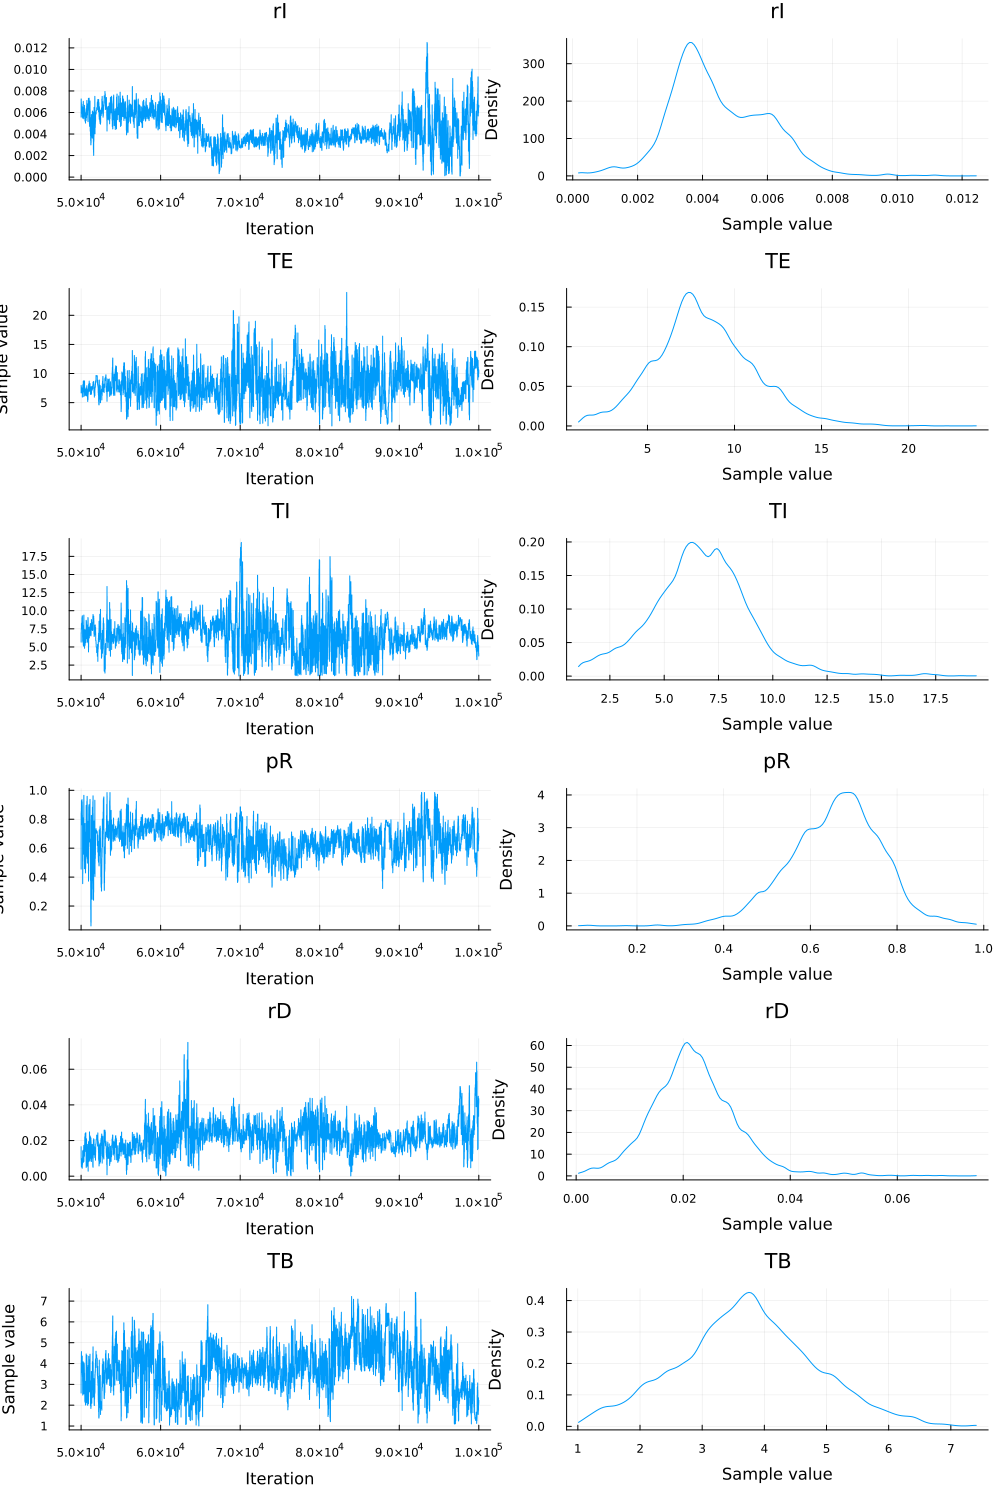

In [18]:
plot(chains_list[1][burnin:end])

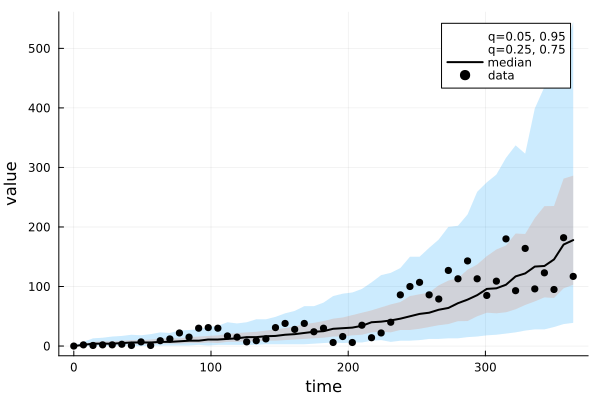

In [32]:
# try visualization function
obs_t = float.(data.Date)
obs_y = data.new_cases

function flow_simfun(par, tobs; dispersion = 2.0)
    p = collect(values(par))
    simulator = MemFlowSEIRSimulator(simulation_function, par, tobs[1], u_initial, x_initial)
    sim = full_simulation(simulator, tobs[end])
    flows = sim[2];
    
    tobs_ind = collect(skipmissing([flows[1,i] in tobs ? i : missing for i in 1:length(flows[1,:])]));
    flows_obs = flows[2:end, tobs_ind];  # +1 because of Julia 1-based indexing
    mu = transpose(cat([diff([0; flows_obs[i,:]]) for i in 1:flows_obs.size[1]]..., dims=2))
    nb_p =  dispersion ./(dispersion .+ mu)
    noisy_flows = rand.(NegativeBinomial.(dispersion, nb_p))
    return noisy_flows
end

res = posterior_predictive_plot(flow_simfun, mixed_chain, obs_t, obs_y, n_ens=1000, state=2; burn_in = 0, quantiles = (0.05, 0.25, 0.5, 0.75, 0.95), legend=:topright)
display(res.plot)

In [36]:
npzwrite("output/cutted_early_flow_converged_samples_50000_out.npy", mixed_chain.value.data)